In [ ]:
!pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
from surprise import NMF, SVD, KNNBasic
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/lastfm-dataset-1K/processed_dataset.csv')
df.head()

,user_id,artist_id,artist_name,track_id,track_name,listen_count,langs
0,user_000001,7e66c9f6-2451-408e-88ff-2af55276caf1,Opiate,00237585-8e04-4cd5-a785-f2185492ab0b,Monday Nightcap,2,en
1,user_000001,9309954a-d550-484d-8cda-8b9f111a7212,Soul Dhamma,d842d1bb-579d-4e76-ad37-a89467c1f113,Flower (The Underwater Garden Dub Aka Scuba Mix),1,en
2,user_000001,4f69da4b-55a9-434c-a150-6de477d8808f,The Young Lovers,d7ffc453-7c42-4fd7-bed6-b749e7a1a60c,You Make Me Dizzy,3,en
3,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,d7e0d2ac-9ce8-4ef8-8716-37f546eb3d23,One Life,7,en
4,user_000001,33672b7a-91e0-4167-8725-a1897584a0da,Kaito,d7d662b6-098e-4961-a0e5-3065ffed95c5,The Universe,4,en


In [ ]:
def deduce_rating(input_df, method="bin"):
  if method == "bin":
    max_count = max(input_df['listen_count'])
    bins = [0, 2, 4, 8, 16, max_count]
    input_df['rating'] = pd.cut(input_df['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5])
  elif method == "average":
    user_avg_count = input_df[['user_id', 'listen_count']].groupby('user_id').mean().reset_index().rename(columns = {'listen_count': 'avg_count'})
    input_df = input_df.merge(right=user_avg_count, on='user_id')
    input_df['rating'] = (input_df['listen_count'] >= input_df['avg_count']).astype(int) + 1
  elif method == "weighted":
    user_max_count = input_df[['user_id', 'listen_count']].groupby('user_id').max().reset_index().rename(columns = {'listen_count': 'max_count'})
    input_df = input_df.merge(right=user_max_count, on='user_id')
    input_df['rating'] = (4*input_df['listen_count'] / input_df['max_count']).apply(np.ceil) 
  return input_df

In [ ]:
avg_processed_df = deduce_rating(df, method='average')
avg_processed_df.head()

,user_id,artist_id,artist_name,track_id,track_name,listen_count,langs,avg_count,rating
0,user_000001,7e66c9f6-2451-408e-88ff-2af55276caf1,Opiate,00237585-8e04-4cd5-a785-f2185492ab0b,Monday Nightcap,2,en,17.517445,1
1,user_000001,9309954a-d550-484d-8cda-8b9f111a7212,Soul Dhamma,d842d1bb-579d-4e76-ad37-a89467c1f113,Flower (The Underwater Garden Dub Aka Scuba Mix),1,en,17.517445,1
2,user_000001,4f69da4b-55a9-434c-a150-6de477d8808f,The Young Lovers,d7ffc453-7c42-4fd7-bed6-b749e7a1a60c,You Make Me Dizzy,3,en,17.517445,1
3,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,d7e0d2ac-9ce8-4ef8-8716-37f546eb3d23,One Life,7,en,17.517445,1
4,user_000001,33672b7a-91e0-4167-8725-a1897584a0da,Kaito,d7d662b6-098e-4961-a0e5-3065ffed95c5,The Universe,4,en,17.517445,1


In [ ]:
w_processed_df = deduce_rating(df, method='weighted')
w_processed_df.head()

,user_id,artist_id,artist_name,track_id,track_name,listen_count,langs,max_count,rating
0,user_000001,7e66c9f6-2451-408e-88ff-2af55276caf1,Opiate,00237585-8e04-4cd5-a785-f2185492ab0b,Monday Nightcap,2,en,326,1.0
1,user_000001,9309954a-d550-484d-8cda-8b9f111a7212,Soul Dhamma,d842d1bb-579d-4e76-ad37-a89467c1f113,Flower (The Underwater Garden Dub Aka Scuba Mix),1,en,326,1.0
2,user_000001,4f69da4b-55a9-434c-a150-6de477d8808f,The Young Lovers,d7ffc453-7c42-4fd7-bed6-b749e7a1a60c,You Make Me Dizzy,3,en,326,1.0
3,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,d7e0d2ac-9ce8-4ef8-8716-37f546eb3d23,One Life,7,en,326,1.0
4,user_000001,33672b7a-91e0-4167-8725-a1897584a0da,Kaito,d7d662b6-098e-4961-a0e5-3065ffed95c5,The Universe,4,en,326,1.0


In [ ]:
df.listen_count.describe()

count    3.286639e+06
mean     3.105519e+01
std      4.387777e+01
min      1.000000e+00
25%      3.000000e+00
50%      1.300000e+01
75%      4.000000e+01
max      3.460000e+02
Name: listen_count, dtype: float64

In [ ]:
reader1 = Reader(rating_scale=(0, 1))
reader2 = Reader(rating_scale=(1, 5))
data_avg = Dataset.load_from_df(avg_processed_df[['user_id', 'track_id', 'rating']], reader1)
data_w = Dataset.load_from_df(w_processed_df[['user_id', 'track_id', 'rating']], reader2)

In [ ]:
unbiased_nmf = NMF()
biased_nmf = NMF(biased=True)

In [ ]:
cross_validate(unbiased_nmf, data_avg, cv=3)

{'fit_time': (282.7349741458893, 283.8048918247223, 282.715270280838),
 'test_mae': array([0.3300928 , 0.32948423, 0.32998983]),
 'test_rmse': array([0.55356702, 0.55317867, 0.55293822]),
 'test_time': (14.41196584701538, 15.074196100234985, 14.354099750518799)}

In [ ]:
cross_validate(unbiased_nmf, data_w, cv=3)

{'fit_time': (286.1133282184601, 280.96778202056885, 280.3645770549774),
 'test_mae': array([0.04160316, 0.04158343, 0.04178305]),
 'test_rmse': array([0.10452802, 0.10457839, 0.10518975]),
 'test_time': (14.504460573196411, 13.282303094863892, 13.301212310791016)}

In [ ]:
cross_validate(biased_nmf, data_avg, cv=3)

{'fit_time': (273.8732876777649, 292.16552925109863, 283.5116219520569),
 'test_mae': array([0.32339387, 0.32329936, 0.32489719]),
 'test_rmse': array([0.56021553, 0.55764785, 0.56062739]),
 'test_time': (14.458827495574951, 16.595274209976196, 14.270854473114014)}

In [ ]:
cross_validate(biased_nmf, data_w, cv=3)

{'fit_time': (282.2412486076355, 291.0680482387543, 283.9489734172821),
 'test_mae': array([0.04660648, 0.03984999, 0.05346794]),
 'test_rmse': array([0.18136182, 0.19259335, 0.17987122]),
 'test_time': (19.925740718841553, 14.64728569984436, 16.139964818954468)}

In [ ]:
sim_options1 = {'name': 'cosine'}
sim_options2 = {'name': 'pearson'}
knn_basic1 = KNNBasic(sim_options=sim_options1)
knn_basic2 = KNNBasic(sim_options=sim_options2)

In [ ]:
cross_validate(knn_basic1, data_avg, cv=3)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'fit_time': (4.807729721069336, 7.247901201248169, 7.418306112289429),
 'test_mae': array([0.30230378, 0.30359109, 0.30219543]),
 'test_rmse': array([0.54982159, 0.550991  , 0.54972305]),
 'test_time': (59.79862380027771, 60.016611099243164, 60.98576498031616)}

In [ ]:
cross_validate(knn_basic1, data_w, cv=3)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'fit_time': (7.3888890743255615, 6.996972560882568, 7.406790494918823),
 'test_mae': array([0.02931909, 0.02956736, 0.02934519]),
 'test_rmse': array([0.0927593 , 0.09419935, 0.093442  ]),
 'test_time': (60.97627663612366, 57.92845797538757, 58.2506947517395)}

In [ ]:
cross_validate(knn_basic2, data_avg, cv=3)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


{'fit_time': (6.740442514419556, 8.724730968475342, 8.695922136306763),
 'test_mae': array([0.30222711, 0.30264726, 0.30321593]),
 'test_rmse': array([0.54975186, 0.55013386, 0.55065046]),
 'test_time': (62.24664855003357, 56.98918414115906, 58.18808126449585)}

In [ ]:
cross_validate(knn_basic2, data_w, cv=3)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


{'fit_time': (8.623029708862305, 8.673853874206543, 8.712932825088501),
 'test_mae': array([0.02977384, 0.02984381, 0.0298074 ]),
 'test_rmse': array([0.09415952, 0.09443642, 0.09396313]),
 'test_time': (62.31596255302429, 62.38454270362854, 58.73543334007263)}

In [ ]:
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
user_track_df = df[['user_id', 'track_id']]
user_degree = user_track_df.groupby("user_id").count().values.reshape(-1)
track_degree = user_track_df.groupby("track_id").count().sample(frac=0.2).values.reshape(-1)

track_artist_df = df[['artist_id', 'track_id']]
artist_degree = track_artist_df.groupby("artist_id").count().values.reshape(-1)

[Text(0.5, 0, 'degree'), Text(0.5, 1.0, 'User')]

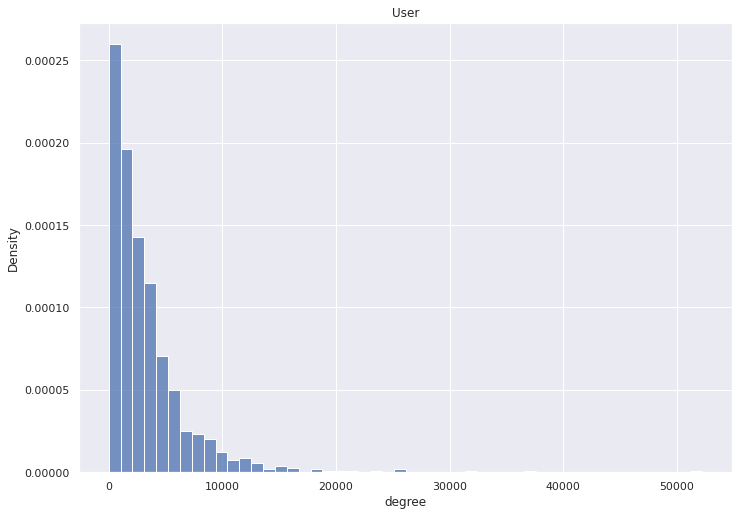

In [ ]:
ax = sns.histplot(user_degree, stat="density", bins=50)
ax.set(xlabel='degree', title="User")

[Text(0.5, 0, 'degree'), Text(0.5, 1.0, 'Track')]

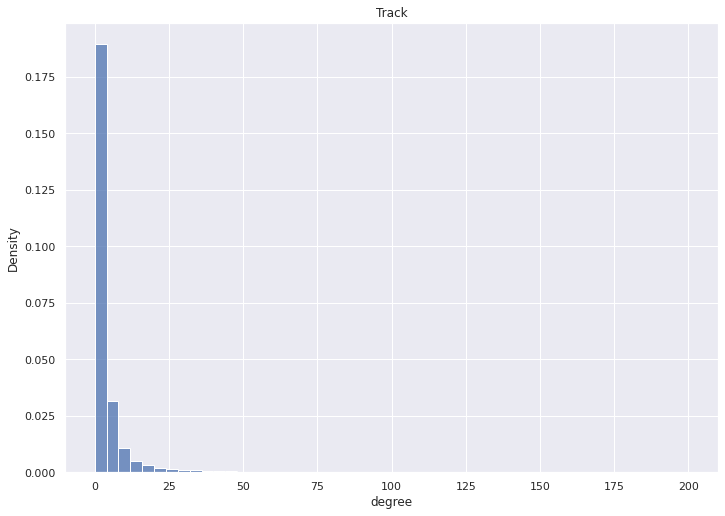

In [ ]:
ax2 = sns.histplot(track_degree, stat='density', bins=50, binrange=(0, 200))
ax2.set(xlabel='degree', title='Track')

[Text(0.5, 0, 'degree'), Text(0.5, 1.0, 'Artist (log scale)')]

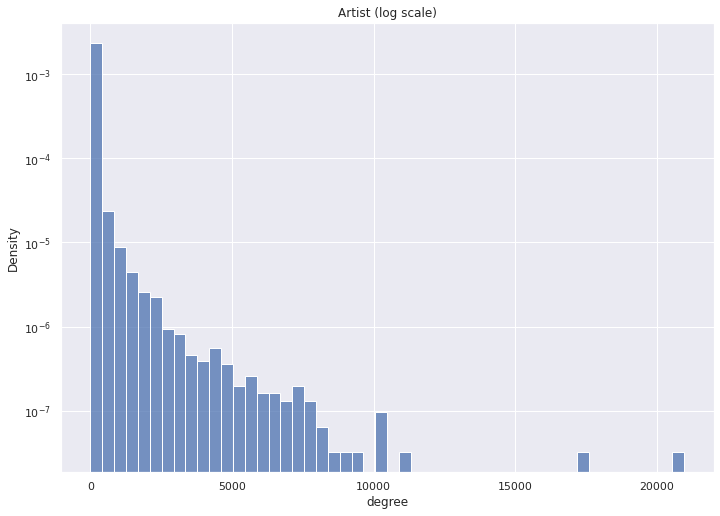

In [ ]:
ax3 = sns.histplot(artist_degree, stat="density", bins=50, log_scale=(False, True))
ax3.set(xlabel='degree', title='Artist (log scale)')